In [1]:
import components
from simulationScripts import createChargingStations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from tqdm import tqdm
import logging
# initialize logger with function
streamHandler = components.loggerConfig()

2023-01-11 21:32:15,176 : root  : loggerConfig : INFO : Logger configured


In [2]:
import os

'''Simulation Name'''
sim_name = "sim1"
result_directory = "results" + os.sep + sim_name
os.makedirs(result_directory, exist_ok=True)

'''choose case'''
case = 2
if case == 0:
    import components.ChaDepLimCon as chargingStationClass
    useOnlyOneChargingStation = True
    useChargingStation = 0
    scaleVehicleArrivals = int(1)
    scalingFactorBtms = 1.3
elif case ==1:
    import components.ChaDepMpcBase as chargingStationClass
    useOnlyOneChargingStation = False
    useChargingStation = 0
    scaleVehicleArrivals = int(1)
    scalingFactorBtms = 1.3
elif case ==2:
    import components.ChaDepMpcBase as chargingStationClass
    useOnlyOneChargingStation = True
    useChargingStation = 0
    scaleVehicleArrivals = int(2)
    scalingFactorBtms = 1.3
'''Infrastructure Creation Mode'''
infrastructure_creation_mode = "numberPlugs" # or taz

'''Simulation'''
timestep = 3 * 60  # in seconds

'''Predictions'''
prediction_add_noise = True

'''Sizing of Charging Stations'''
# demand charge in $/kWh
a_cost_sizing = 20
# free power demand as ratio to max charging power
P_free_Ratio_sizing = 0.0
# btms cost per cycle in $/kWh
b_cost_sizing = 300/5000
c_cost_sizing = 0.15

'''Creating optimal day ahead plan'''

###########################################
## Plots ##
###########################################
showPlots = True
directory_figures = result_directory + os.sep + "figures"
os.makedirs(directory_figures, exist_ok=True)
plotPrediction = True
plotSizing = True

###########################################
## FILEPATHS Files ##
###########################################
plots_path = "results" + os.sep + "plots" + os.sep + sim_name 
#'''Simulation Broker'''
path_Sim = "test_data" + os.sep + "beam1" + os.sep + "beam1-0.csv"
dtype_Sim = {
       'time': 'int64', 'type': 'category', 'vehicle': 'int64', 'parkingTaz': 'category','chargingPointType': 'category', 
       'primaryFuelLevel': 'float64', 'mode': 'category', 'currentTourMode': 'category', 'vehicleType': 'category', 
       'arrivalTime': 'float64', 'departureTime': 'float64', 'linkTravelTime': 'string', 'primaryFuelType': 'category', 
       'parkingZoneId': 'category','duration': 'float64' 
        }
#'''Vehicle Generator'''
path_DataBase = "test_data" + os.sep + "vehicleFiles" + os.sep + "vehicletypes-Base_2035_20210204_updated.csv"
#'''Infrastructure File'''
path_infrastructure = "test_data" + os.sep + "beam1" + os.sep + "gemini-base-scenario-3-charging-no-household-infra16.csv"

### simulation

#### initialize helper objects for simulation
- SimulationBroker
- VehicleGenerator
- ResultWriter

In [3]:
'''Initialize helper classes'''
# simulation broker
SimBroker = components.SimBroker(path_Sim, dtype_Sim)
logging.info("SimBroker initialized")
# vehicle generator
VehicleGenerator = components.VehicleGenerator(path_Sim, dtype_Sim, path_DataBase)
logging.info("VehicleGenerator initialized")
# result writer
ResultWriter = components.ResultWriter(result_directory)
logging.info("ResultWriter initialized")

2023-01-11 21:32:15,368 : root  : <module> : INFO : SimBroker initialized
2023-01-11 21:32:17,350 : root  : <module> : INFO : VehicleGenerator initialized
2023-01-11 21:32:17,356 : root  : <module> : INFO : ResultWriter initialized


#### create charging stations
1) map parkingZoneIds to charging stations with a dictionary
2) create charging Stations

In [4]:
chargingStationMappedToParkingZoneId, chargingStationMappedToTaz = createChargingStations.createMaps(path_infrastructure, mode = infrastructure_creation_mode)
chargingStations = createChargingStations.createChargingStations(chargingStationMappedToParkingZoneId, path_infrastructure, chargingStationClass, ResultWriter, SimBroker)

2023-01-11 21:32:17,563 : root  : createMaps : INFO : charging stations mapped to parkingZoneId
2023-01-11 21:32:17,565 : root  : createChargingStations : INFO : creating charging stations of type <class 'components.ChaDepMpcBase.ChaDepMpcBase'>
2023-01-11 21:32:17,657 : root  : createChargingStations : INFO : chargingStation-1 was created with 208 charging bays and 26000.0kWh BTM-Storage
2023-01-11 21:32:17,663 : root  : createChargingStations : INFO : chargingStation-2 was created with 207 charging bays and 25875.0kWh BTM-Storage
2023-01-11 21:32:17,668 : root  : createChargingStations : INFO : chargingStation-3 was created with 93 charging bays and 11625.0kWh BTM-Storage


 initialize helper objects for simulation input

In [5]:
PhySimDummy = components.PhySimDummy(chargingStations)
logging.info("PhySimDummy initialized")
DermsDummy  = components.DermsDummy(chargingStations)
logging.info("DermsDummy initialized")

2023-01-11 21:32:17,730 : root  : <module> : INFO : PhySimDummy initialized
2023-01-11 21:32:17,731 : root  : <module> : INFO : DermsDummy initialized


#### initialize simulation
initialize Grid Constraints and actual time of charging Station

In [6]:
#reduce number of chargingStation for testing
if useOnlyOneChargingStation:
    chargingStations = [chargingStations[useChargingStation]]
    logging.info('we reduced the number of charging stations to 1')

2023-01-11 21:32:17,801 : root  : <module> : INFO : we reduced the number of charging stations to 1


In [7]:
'''Simulation settings:'''
logging.info("timestep is set to " + str(timestep) + " seconds")

2023-01-11 21:32:17,873 : root  : <module> : INFO : timestep is set to 180 seconds


generate predictions for power use of charging station

2023-01-11 21:32:22,473 : root  : <module> : INFO : generated predictions for chargingStation-1
2023-01-11 21:32:22,691 : root  : <module> : INFO : plotted predictions for chargingStation-1


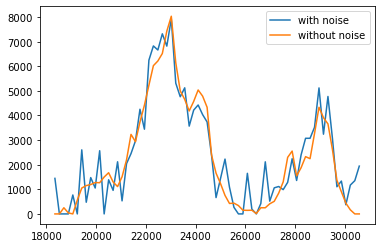

In [8]:
# generate predictions or power usage at charging stations
if chargingStationClass == components.ChaDepMpcBase:
    for x in chargingStations:
        x.generate_prediction(path_BeamPredictionFile = path_Sim, dtype = dtype_Sim, path_DataBase = path_DataBase, timestep = timestep, addNoise = prediction_add_noise)
        logging.info("generated predictions for " + str(x.ChargingStationId))
# plot predictions
if plotPrediction:
    for x in chargingStations:
        ax = x.plot_prediction(directory_figures)
        logging.info("plotted predictions for " + str(x.ChargingStationId))
if showPlots:
    plt.show()

BTMS size optimization

see mpcBase.md for explanations

2023-01-11 21:32:22,863 : root  : <module> : INFO : starting btms size optimization
2023-01-11 21:32:22,865 : root  : <module> : INFO : optimizing btms size for chargingStation-1
2023-01-11 21:32:22,950 : root  : determine_btms_size : INFO : 
----- 
 btms size optimization for charging station chargingStation-1 
-----
2023-01-11 21:32:23,489 : root  : solver_algorithm : INFO : SOLVER STATS: solver name: ECOS | solver status: optimal | optimal value 457.4681803036646 |iterations: 16 | setup_time 0.0001816 | solve_time 0.0014409
2023-01-11 21:32:23,502 : root  : <module> : INFO : Optimization with free power level of 0.00 kW and a demand charge of 0.10 €/day*kW and a BTMS cost of 0.06000 €/kWh and an electricity cost of 0.150 €/kWh
2023-01-11 21:32:23,503 : root  : <module> : INFO : The determined effective BTMS size is 1954.45 kWh. The total cost is 457.47 €.The associated C-Rating is 2.53
The cost-value is $457.47 from which $282.97 is associated with demand charge, $140.30 is associat

c:\Users\akaju\anaconda3\envs\py_btms_controller\lib\site-packages\ipykernel_launcher.py:84: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


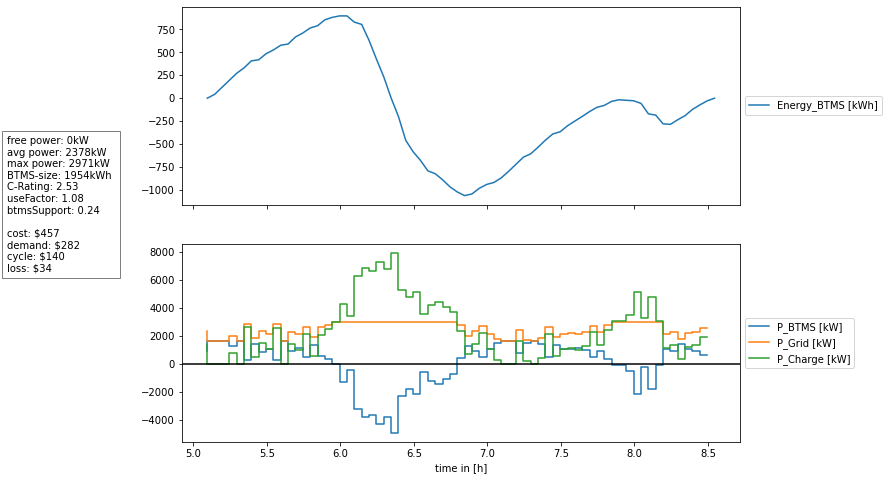

In [9]:
if chargingStationClass == components.ChaDepMpcBase:
    logging.info("starting btms size optimization")
    a = a_cost_sizing/30 * ((SimBroker.t_max - SimBroker.t_act)/3.6e3) / 24 # demand charge per day
    # free power, after which demand charge is applied, as ratio to avg power
    P_free_Ratio = P_free_Ratio_sizing
    # btms cost per cycle per kWh (price per kWh/ possible cycles)
    b = b_cost_sizing
    c = c_cost_sizing      # electricity cost per kWh

    for i in range(0, len(chargingStations)):
        logging.info("optimizing btms size for " + str(chargingStations[i].ChargingStationId))
        x = chargingStations[i]
        # determine P_free
        avgPower = sum(x.PredictionPower*timestep) / \
            (max(x.PredictionTime) + timestep - min(x.PredictionTime))
        P_free = P_free_Ratio * avgPower

        # btms size optimization
        time, time_x, btms_size, P_Grid, P_BTMS, P_BTMS_Ch, P_BTMS_DCh, E_BTMS, P_Charge, cost = x.determine_btms_size(
            SimBroker.t_act, SimBroker.t_max, timestep, a, b, c, P_free)

        time = time/3.6e3  # conversion to hours
        time_x = time_x/3.6e3

        str1 = 'Optimization with free power level of {:.2f} kW'.format(P_free)
        str2 = ' and a demand charge of {:.2f} €/day*kW'.format(a)
        str3 = ' and a BTMS cost of {:.5f} €/kWh'.format(b)
        str4 = ' and an electricity cost of {:.3f} €/kWh'.format(c)
        logging.info(str1 + str2 + str3 + str4)
        str1 = 'The determined effective BTMS size is {:.2f} kWh.'.format(btms_size)
        str2 = ' The total cost is {:.2f} €.'.format(cost)
        cRating = max(abs(P_BTMS))/btms_size
        str3 = 'The associated C-Rating is {:.2f}'.format(cRating)
        logging.info(str1 + str2 + str3)
        # btmsDCh is always negative
        costLoss = c*(sum(P_BTMS_Ch*timestep/3.6e3) +
                        sum(P_BTMS_DCh*timestep/3.6e3))
        costCycle = b*sum(P_BTMS_Ch*timestep/3.6e3)
        # convert the upper code in the new format
        str1 = 'The cost-value is ${:.2f}'.format(cost) + ' from which ${:.2f}'.format(a*(max(P_Grid)-P_free)) + ' is associated with demand charge, ${:.2f}'.format(costCycle) + ' is associated with BTMS degradation and ${:.2f}'.format(costLoss) + ' is associated with energy losses'
        print(str1)
        logging.info(str1)
        E_total = sum(timestep/3.6e3*P_Charge)
        str1 = 'The total delivered energy to the vehicles is {:.2f} kWh, which results in an average power of {:.2f} kW'.format(E_total, E_total/(max(time)-min(time) + timestep/3.6e3))
        str2 = '{:.2f} kWh were delivered by the BTMS and charging losses of {:.2f} kWh occured.'.format(-sum(P_BTMS_DCh*timestep/3.6e3), sum(P_BTMS_DCh*timestep/3.6e3) + sum(P_BTMS_Ch*timestep/3.6e3))
        str3 = 'The maximal grid power is {:.2f} kW'.format(max(P_Grid))
        #print(str1, str2, str3)
        logging.info(str1 + str2 + str3)

        if plotSizing:
            cRating = max(abs(P_BTMS))/btms_size
            E_total = sum(timestep/3.6e3*P_Charge)
            avgPower = int(E_total/(max(time)-min(time) + timestep/3.6e3))
            # usage factor, how many cycles btms is discharged
            useFactor = -sum(P_BTMS_DCh*timestep/3.6e3) / btms_size
            # we also define a usage factor as fraction of energy by btms and compare to the total charged energy
            btmsSupport = btms_size / sum(P_Charge*timestep/3.6e3)
            # btmsDCh is always negative
            costLoss = c*(sum(P_BTMS_Ch*timestep/3.6e3) +
                        sum(P_BTMS_DCh*timestep/3.6e3))
            costCycle = b*sum(P_BTMS_Ch*timestep/3.6e3)
            costDemand = a*(max(P_Grid)-P_free)
            info_string1 = 'free power: ' + str(int(P_free)) + 'kW \navg power: ' + str(int(avgPower)) + 'kW \nmax power: ' + str(int(max(P_Grid))) + 'kW \nBTMS-size: ' + str(int(btms_size)) + 'kWh \nC-Rating: ' + "{:.2f}".format(
                cRating) + ' \nuseFactor: ' + "{:.2f}".format(useFactor) + ' \nbtmsSupport: ' + "{:.2f}".format(btmsSupport) + ' \n\ncost: $' + str(int(cost)) + ' \ndemand: $' + str(int(costDemand)) + '\ncycle: $' + str(int(costCycle)) + '\nloss: $' + str(int(costLoss))

            fig, ax = plt.subplots(2, 1, sharex=True)

            ax[0].plot(time_x, E_BTMS, label="Energy_BTMS [kWh]")
            ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            fig.text(-0.12, 0, info_string1, horizontalalignment='right', verticalalignment='center',
                    multialignment='left', transform=ax[0].transAxes, bbox=dict(facecolor='none', edgecolor='grey', pad=5.0))
            #ax[0].text(0.5, 1, info_string2, horizontalalignment='right', verticalalignment='top', transform=ax[0].transAxes)

            ax[1].step(time, P_BTMS, label="P_BTMS [kW]")
            ax[1].step(time, P_Grid, label="P_Grid [kW]")
            ax[1].step(time, P_Charge, label="P_Charge [kW]")
            ax[1].axhline(0, color='black')
            ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax[1].set_xlabel("time in [h]")
            fig.set_size_inches(10, 8)
            print(cost)
            fig.savefig(directory_figures + os.sep + x.ChargingStationId + '_sizing.png', bbox_inches='tight')
            if showPlots:
                fig.show()
            else:
                fig.close()

scale BTMS size

In [10]:
if chargingStationClass == components.ChaDepMpcBase:
    factor = scalingFactorBtms * scaleVehicleArrivals
    for x in chargingStations:
        x.BtmsSize = factor * x.determinedBtmsSize
        x.BtmsMaxPower= factor * x.determinedMaxPower
        if factor != 1.0:
            logging.info(x.ChargingStationId + ' btms size was changed to {:.2f} kWh and max power to {:.2f} kW with a factor of {:.2f}'.format(x.BtmsSize, x.BtmsMaxPower, factor))

2023-01-11 21:32:24,087 : root  : <module> : INFO : chargingStation-1 btms size was changed to 5081.56 kWh and max power to 12875.80 kW with a factor of 2.60


In [11]:
'''write charging station properties to ResultWriter'''
ResultWriter.save_charging_station_properties(chargingStations)
logging.info('Charging station properties saved')

2023-01-11 21:32:24,173 : root  : <module> : INFO : Charging station properties saved


create optimal day-ahead plan

planning() (MPC Base - convex)

2023-01-11 21:32:24,259 : root  : <module> : INFO : creating day ahead plan
2023-01-11 21:32:24,261 : root  : <module> : INFO : parameters for creating day ahead plan: demand charge cost = 0.10, free power ratio = 0.00, btms degradation cost = 0.06, electricity cost = 0.15, waiting time cost = 10.00, average charging speed = 100.00, beta = 0.15, cRating not enforced
2023-01-11 21:32:24,265 : root  : <module> : INFO : Creating Day Ahead plan for chargingStation-1
2023-01-11 21:32:24,473 : root  : day_planning : INFO : 
----- 
 day planning for charging station chargingStation-1 
-----
2023-01-11 21:32:25,799 : root  : solver_algorithm : INFO : SOLVER STATS: solver name: ECOS | solver status: optimal | optimal value 914.950869352851 |iterations: 13 | setup_time 0.0008501 | solve_time 0.0034264
2023-01-11 21:32:25,800 : root  : day_planning : INFO : self tracked times: setup time: 0.20599627494812012, solve time: 1.3270518779754639, total action time: 1.533048152923584
2023-01-11 21:32:25

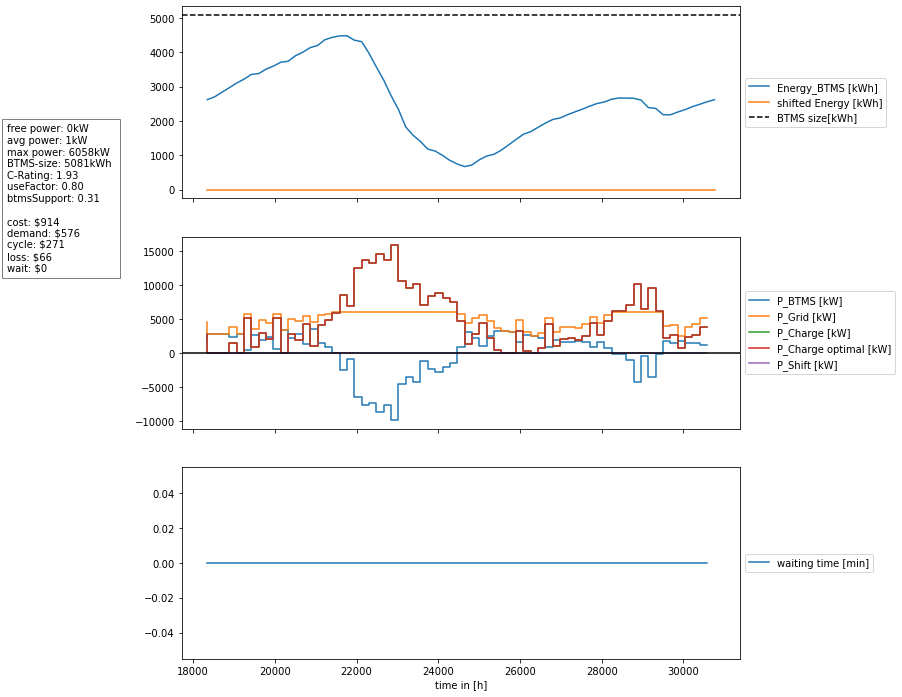

In [12]:
if chargingStationClass == components.ChaDepMpcBase:
    logging.info('creating day ahead plan')
    a = 20/30 * ((SimBroker.t_max - SimBroker.t_act)/3.6e3) / 24  # demand charge cost
    # free power, after which demand charge is applied, as ratio to avg power
    P_free_Ratio = 0
    b = 300/5000                    # btms degradation cost
    c = 0.15                        # electricity cost
    d_param = 10                    # waiting time cost of a vehicle in $/h
    P_chAvg = 100                   # average charging speed in kW of an vehicle
    beta = 0.15                     # bandwith for energy level curve
    # if choosen different from None, constraints to enforce c rate are applied
    cRating = None
    Graph = True
    if cRating == None:
        cPrint = ', cRating not enforced'
    else:
        cPrint = ", cRating = {:.2f}".format(cRating)

    logging.info("parameters for creating day ahead plan: demand charge cost = {:.2f}, free power ratio = {:.2f}, btms degradation cost = {:.2f}, electricity cost = {:.2f}, waiting time cost = {:.2f}, average charging speed = {:.2f}, beta = {:.2f}".format(a, P_free_Ratio, b, c, d_param, P_chAvg, beta) + cPrint)

    if False:  # make a time varying d-vector
        x = chargingStations[0]
        time = np.array(x.PredictionTime)
        power = np.array(x.PredictionPower)
        idx = np.logical_and(time >= SimBroker.t_act, time <= SimBroker.t_max)
        time_new = time[idx]
        #d = []
        # for i in range(0,sum(idx)):
        # for time varying vector
        # if time_new[i]< 21800:
        #     d.append(1)
        # elif time_new[i] < 26000:
        #     d.append(10)
        # elif time_new[i] < 28000:
        #     d.append(1)
        # elif time_new[i] < 29500:
        #     d.append(10)
        # else:
        #     d.append(2)
        # d.append(d_param)
        #logging.info('added time varying d-vector: ' + str(d))
    else: 
        d = d_param # transformed to list by .planning() function

    for x in chargingStations:
        logging.info("Creating Day Ahead plan for " + x.ChargingStationId)
        x.PredictionPower = np.array(x.PredictionPower) * scaleVehicleArrivals
        x.PredictionPower = x.PredictionPower.tolist()
        
        avgPower = sum(x.PredictionPower*timestep) / \
            (max(x.PredictionTime) + timestep - min(x.PredictionTime))
        P_free = P_free_Ratio * avgPower

        time, time_x, P_Grid, P_BTMS, P_BTMS_Ch, P_BTMS_DCh, E_BTMS, E_Shift, P_Charge, P_Shift, t_wait_val, cost_t_wait, cost = x.day_planning(
            SimBroker.t_act, SimBroker.t_max, timestep, a, b, c, d, P_free, P_chAvg, beta, cRating)

        if Graph:
            cRating = max(abs(P_BTMS))/x.BtmsSize
            E_total = sum(timestep/3.6e3*P_Charge)
            avgPower = int(E_total/(max(time)-min(time) + timestep/3.6e3))
            useFactor = -sum(P_BTMS_DCh*timestep/3.6e3) / x.BtmsSize
            btmsSupport = x.BtmsSize / E_total
            # btmsDCh is always negative
            costLoss = c*(sum(P_BTMS_Ch*timestep/3.6e3) +
                          sum(P_BTMS_DCh*timestep/3.6e3))
            costCycle = b*sum(P_BTMS_Ch*timestep/3.6e3)
            costDemand = a*(max(P_Grid)-P_free)

            info_string1 = 'free power: ' + str(int(P_free)) + 'kW \navg power: ' + str(int(avgPower)) + 'kW \nmax power: ' + str(int(max(P_Grid))) + 'kW \nBTMS-size: ' + str(int(x.BtmsSize)) + 'kWh \nC-Rating: ' + "{:.2f}".format(cRating) + ' \nuseFactor: ' + "{:.2f}".format(
                useFactor) + ' \nbtmsSupport: ' + "{:.2f}".format(btmsSupport) + ' \n\ncost: $' + str(int(cost)) + ' \ndemand: $' + str(int(costDemand)) + '\ncycle: $' + str(int(costCycle)) + '\nloss: $' + str(int(costLoss)) + '\nwait: $' + str(int(cost_t_wait))
            logging.info(info_string1)

            fig, ax = plt.subplots(3, 1, sharex=True)
            ax[0].plot(time_x, E_BTMS, label="Energy_BTMS [kWh]")
            ax[0].plot(time_x, E_Shift, label="shifted Energy [kWh]")
            ax[0].axhline(x.BtmsSize, label="BTMS size[kWh]",
                          color="black", linestyle="--")
            ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            fig.text(-0.12, 0, info_string1, horizontalalignment='right', verticalalignment='center',
                     multialignment='left', transform=ax[0].transAxes, bbox=dict(facecolor='none', edgecolor='grey', pad=5.0))
            #ax[0].text(0.5, 1, info_string2, horizontalalignment='right', verticalalignment='top', transform=ax[0].transAxes)

            ax[1].step(time, P_BTMS, label="P_BTMS [kW]")
            ax[1].step(time, P_Grid, label="P_Grid [kW]")
            ax[1].step(time, P_Charge-P_Shift, label="P_Charge [kW]")
            ax[1].step(time, P_Charge, label="P_Charge optimal [kW]")
            ax[1].step(time, P_Shift, label="P_Shift [kW]")
            ax[1].axhline(0, color='black')
            ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

            if sum(t_wait_val) < 0.0005:
                t_wait_val = np.zeros_like(t_wait_val)
            ax[2].step(time, t_wait_val*60, label="waiting time [min]")
            ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

            ax[2].set_xlabel("time in [h]")

            fig.set_size_inches(10, 12)

            #TODO: add flexible electricity prices - what happens then?


#### run simulation

In [13]:
SimBroker.reset()
ResultWriter.reset()

# import cProfile, pstats, io
# from pstats import SortKey
# pr = cProfile.Profile()
# pr.enable()

# charging station BtmsEn and P_GridLast was initialized in planning()-function

# determine iterations for progress bar
max_iter = np.ceil((SimBroker.SimRes.index[-1] - SimBroker.SimRes.index[0])/timestep)
# print maximum iterations
logging.info("\n-------\nstarting simulation.\n-------\n maximum iterations: " + str(max_iter))

# change logging level to WARNING
streamHandler.setLevel(logging.WARNING)

#initialize progress bar
progress_bar = tqdm(desc = "MPC simulation", total=max_iter)

while not SimBroker.eol():
    # update progress bar
    progress_bar.update(1)
    
    # Sim Broker Step
    slice = SimBroker.step(timestep)
    logging.info("\n-|-|-|-|-|\ntimestep to {:.0f}s / {:.0f}s | iteration: {:.0f}".format(SimBroker.t_act, SimBroker.t_max, SimBroker.iteration))

    #update values from DERMS and PhysicalSimulation
    for x in chargingStations:
        # update SiteNet Power Limits from Derms
        GridPowerLower, GridPowerUpper = DermsDummy.output(x.ChargingStationId)
        x.update_from_derms(GridPowerLower, GridPowerUpper)
        logging.info("update GridPowerLimits from Derms: {:.0f}kW - {:.0f}kW".format(GridPowerLower, GridPowerUpper))
        # update CES SOC from PhysicalSimulation
        x.update_from_grid_simulation(PhySimDummy.output(x.ChargingStationId))
        logging.info("update CES SOC from PhySim: {:.0f}kWh".format(PhySimDummy.output(x.ChargingStationId)))

    # generate Vehicles if charging Plug in event
    logging.info("adding vehicles of slice to charging stations")
    for i in range(0, len(slice)):
        if slice.iloc[i]["type"] == "ChargingPlugInEvent":
            # generate vehicle
            for repeat in range(scaleVehicleArrivals):
                vehicle = VehicleGenerator.generate_vechicle_from_df_slice(slice.iloc[i])
                vehicleId = vehicle.VehicleId
                scale = len(str(vehicleId))
                vehicleId = repeat * 10 ** (scale+2) + vehicleId
                # let vehicle arrive at a charging station - here depending on taz
                taz = int(slice.iloc[i]["parkingTaz"]) # this is a str
                #find out which chargingStation belongs to the taz
                res = chargingStationMappedToTaz.isin([taz]).any().values
                index = np.where(res == True)[0][0]

                #let vehicles arrive at designated chargingStation
                if useOnlyOneChargingStation:
                    if index == useChargingStation:
                        chargingStations[0].arrival(vehicle, SimBroker.t_act)
                else: 
                    chargingStations[index].arrival(vehicle, SimBroker.t_act)

    ## control action and simulation
    
    # call step function
    for x in chargingStations:
        logging.info("--- calling .step() charging station %s | iteration %s | connected vehicles %s  ---" % (x.ChargingStationId, str(SimBroker.iteration), str(len(x.ChBaVehicles) - x.ChBaVehicles.count(False))))
        if isinstance(x, components.ChaDepMpcBase):
            x.step(timestep)
        else:
            x.step(timestep)
        logging.info("--- finished .step() charging station %s | iteration %s | connected vehicles %s---" % (x.ChargingStationId, str(SimBroker.iteration), str(len(x.ChBaVehicles) - x.ChBaVehicles.count(False))))
    
    # provide outputs
    for x in chargingStations:
        PhySimDummy.input(x.ChargingStationId, sum(x.ChBaPower), x.P_BTMS, timestep)
        DermsDummy.input(x.ChargingStationId, x.PowerDesire)


progress_bar.close()

# change logging level back to INFO
streamHandler.setLevel(logging.INFO)

logging.info("Simulation terminated. final number of iterations: {:.0f}, final time: {:.0f}s".format(SimBroker.iteration, SimBroker.t_act))

# pr.disable()
# pr.dump_stats('profile.prof')
# s = io.StringIO()
# sortby = SortKey.TIME
# ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
# ps.print_stats()
# print(s.getvalue())

2023-01-11 21:32:26,353 : root  : <module> : INFO : 
-------
starting simulation.
-------
 maximum iterations: 69.0


MPC simulation:   0%|          | 0/69.0 [00:00<?, ?it/s]c:\Users\akaju\anaconda3\envs\py_btms_controller\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)
MPC simulation: 100%|██████████| 69/69.0 [00:14<00:00,  4.87it/s]

2023-01-11 21:32:40,517 : root  : <module> : INFO : Simulation terminated. final number of iterations: 68, final time: 30583s


### save results

In [14]:
ResultWriter.save()

In [15]:
showVehicle = 3
print("current time: ", SimBroker.t_act)
print(chargingStations[0].ChBaVehicles[showVehicle])
print("\nVehicle Number in ChBa: ", showVehicle)
if chargingStations[0].ChBaVehicles[showVehicle] != False:
    lower, upper = chargingStations[0].ChBaVehicles[showVehicle].get_charging_trajectories(SimBroker.t_act, timestep, 10, maxPowerPlug = chargingStations[0].ChBaMaxPower[showVehicle])
    fig, ax = plt.subplots(1,1)
    plt.plot(lower, label="lower bound")
    plt.plot(upper, label= "upper bound")
    plt.legend()
    ax.set_xlabel("control steps")
    ax.set_ylabel("energy [kWh]")

showVehicle += 1

current time:  30583
False

Vehicle Number in ChBa:  3


In [16]:
if False:
    # plot charging and btms power
    Station = "chargingStation-1"
    df4 = ResultWriter.ChargingStationStates.loc[ResultWriter.ChargingStationStates.ChargingStationID==Station]
    fig, ax = plt.subplots(2,1)
    ax[0].step(df4["time"], df4["BtmsPower"], label="P_BTMS [kW]")
    ax[0].step(df4["time"], df4["TotalChargingPower"], label="P_Charge [kW]")
    ax[0].step(df4["time"], df4["GridPower"], label="P_Grid [kW]")
    ax[0].legend()
    if isinstance(chargingStationClass, components.ChaDepMpcBase):
        ax[0].axhline(chargingStations[0].P_GridMaxPlanning, color = 'black')
    ax[0].set_xlabel("time in [h]")
    ax[0].set_ylabel("power in [kW]")

    ax[1].step(df4["time"], df4["BtmsEnergy"], label="BtmsEnergy [kWh]")
    ax[1].axhline(ResultWriter.chargingStationProperties.loc[ResultWriter.chargingStationProperties.ChargingStationId == Station].BtmsSize.values[0], color='black')
    ax[1].axhline(0, color='black')
    ax[1].set_xlabel("time in [h]")
    ax[1].set_ylabel("energy in [kWh]")
    ax[1].legend()

    fig.set_size_inches(10,8)

In [17]:
VehicleStates = ResultWriter.VehicleStates.loc[ResultWriter.VehicleStates.VehicleId == 6506887.0]
VehicleStates.head(1)

,time,VehicleId,ChargingStationId,QueueOrBay,ChargingPower,possiblePower,ChargingDesire,VehicleDesiredEnd,VehicleEnergy,VehicleDesiredEnergy,VehicleSoc,EnergyLag,TimeLag
108,20323,6506887,chargingStation-1,Bay,150.0,150.0,1.186099,20769,45.10866,67.150326,0.537303,-3.458333,0


In [18]:
VehicleEvents = ResultWriter.Events.loc[ResultWriter.Events.VehicleId == 6506887.0]
VehicleEvents.head(1)

,time,Event,ChargingStationId,VehicleId,QueueOrBay,ChargingDesire,VehicleType,VehicleArrival,VehicleDesiredEnd,VehicleEnergy,VehicleDesiredEnergy,VehicleSoc,VehicleMaxEnergy,VehicleMaxPower,ChargingBayMaxPower
143,20323,ArrivalEvent,chargingStation-1,6506887,,1.186099,ev-L1-0-to-50000-LowTech-2035-SUV-BEV_300,20240,20769,45.10866,67.150326,0.537303,83.953903,150.0,NaN


In [19]:
ResultWriter.MpcStats.head(1)

,time,ChargingStationID,Status,Iterations,OptimalValue,SetupTime,SolveTime,SolverName,sum_t1,sum_t2,T1,T2
0,18343,chargingStation-1,optimal,22,4.885229,0.000065,0.000657,ECOS,"[1.725775161226226e-05, 1.7160431870166224e-05...","[1.725775161226226e-05, 1.7160431870166224e-05...","[[1.725775161226226e-05, 1.7160431870166224e-0...","[[1.725775161226226e-05, 1.7160431870166224e-0..."


#### plot results

(-254.07795849762343, 5709.131727441599)
2023-01-11 21:32:41,803 : root  : <module> : INFO : figure printed


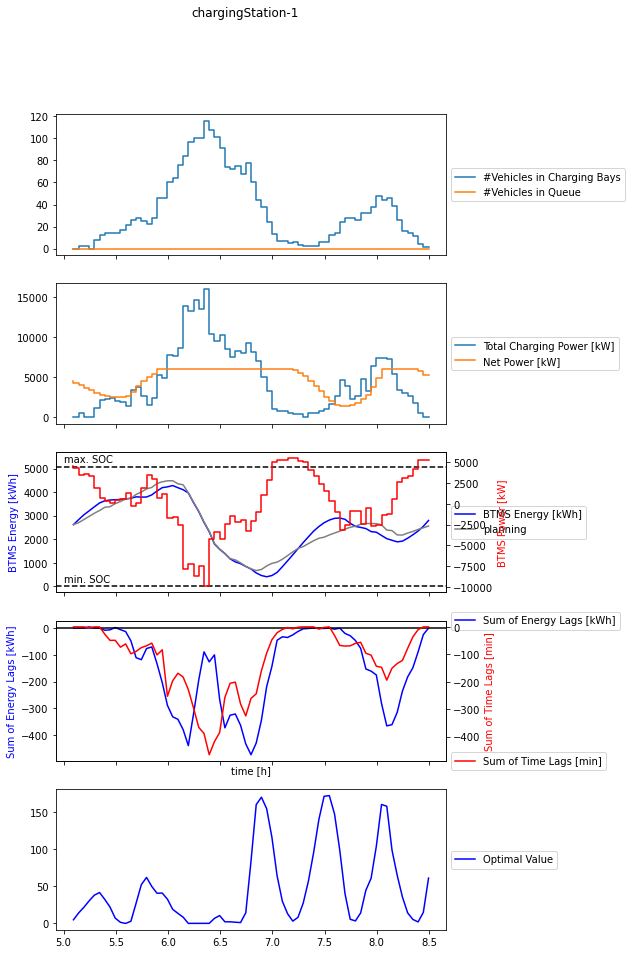

In [20]:
if True:
    import matplotlib.pyplot as plt
    loadDataFromFile = False
    plotChargingStation = 0

    if loadDataFromFile == True:
        # need to add code to load this from file
        pass
    else:
        ChSt = ResultWriter.ChargingStationStates.loc[ResultWriter.ChargingStationStates.ChargingStationID ==
                                                    chargingStations[plotChargingStation].ChargingStationId]

    fig, ax = plt.subplots(5, 1, sharex=True)
    fig.suptitle(chargingStations[plotChargingStation].ChargingStationId)
    ax[0].step(ChSt.time/3600, ChSt.BaysNumberOfVehicles,
            label="#Vehicles in Charging Bays")
    ax[0].step(ChSt.time/3600, ChSt.QueueNumberOfVehicles,
            label="#Vehicles in Queue")
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # ax[0].grid()

    #ax[1].step(ChSt.time/3600, ChSt.GridPowerUpper, label = "Upper Power Limit [kW]")
    ax[1].step(ChSt.time/3600, ChSt.TotalChargingPower,
            label="Total Charging Power [kW]")

    ax[1].step(ChSt.time/3600, ChSt.TotalChargingPower +
            ChSt.BtmsPower, label="Net Power [kW]")
    if isinstance(chargingStationClass, components.ChaDepMpcBase):
        ax[1].axhline(chargingStations[0].P_GridMaxPlanning, color = 'black', label = 'P_Max_Planning [kW]') # TODO need to save P Grid Max Planning
    #ax[1].step(ChSt.time/3600, ChSt.BtmsPower, label = "Net Power [kW]")
    if isinstance(chargingStationClass, components.ChaDepMpcBase):
        ax[1].step(np.array(chargingStations[0].PredictionTime)/3600, chargingStations[0].PredictionPower , label="unconstrained Power [kW]")
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # ax[1].grid()

    ax[2].plot(ChSt.time/3600, ChSt.BtmsEnergy,
            label="BTMS Energy [kWh]", color="blue")
    ax[2].set_ylabel("BTMS Energy [kWh]", color="blue")
    if case == 2 or case == 3:
        # ax[2].plot(ChSt.time/3600, chargingStations[plotChargingStation].E_BtmsLower[0:np.shape(
        #     ChSt.time)[0]], color='grey', label="lower bound planning")
        # ax[2].plot(ChSt.time/3600, chargingStations[plotChargingStation].E_BtmsUpper[0:np.shape(
        #     ChSt.time)[0]], color='grey', label="upper bound planning")
        ax[2].plot(ChSt.time/3600, chargingStations[plotChargingStation].E_BtmsPlanned[0:np.shape(
            ChSt.time)[0]], color='grey', label="planning")

    y1 = chargingStations[plotChargingStation].BtmsSize * \
        chargingStations[plotChargingStation].BtmsMaxSoc
    ax[2].axhline(y=y1, linestyle="--", color="black")

    y2 = chargingStations[plotChargingStation].BtmsSize * \
        chargingStations[plotChargingStation].BtmsMinSoc
    ax[2].axhline(y=y2, linestyle="--", color="black")
    # ax[2].grid()

    ylim = ax[2].get_ylim()
    ax[2].set_ylim([ylim[0], 1.07*ylim[1]])
    ylim = ax[2].get_ylim()
    print(ylim)
    dy = ylim[1]-ylim[0]
    xlim = ax[2].get_xlim()
    x = xlim[0]
    dx = xlim[1]-xlim[0]
    ax[2].text(x+0.02*dx, y1+0.03*dy, "max. SOC")
    ax[2].text(x+0.02*dx, y2+0.03*dy, "min. SOC")

    ax1 = ax[2].twinx()
    ax1.step(ChSt.time/3600, ChSt.BtmsPower, label="BTMS Power [kW]", color="red")
    ax1.set_ylabel("BTMS Power [kW]", color="red")
    #ax1.set_ylim([-chargingStations[plotChargingStation].GridPowerMax_Nom,chargingStations[plotChargingStation].GridPowerMax_Nom])
    ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax[3].plot(ChSt.time/3600, ChSt.EnergyLagSum,
            label="Sum of Energy Lags [kWh]", color="blue")
    if isinstance(chargingStationClass, components.ChaDepMpcBase):
        ax[3].plot(ChSt.time/3600, chargingStations[0].PredictionEnergyLag, label="Prediction Energy Lags [kWh]", color="mediumslateblue")
    ax[3].axhline(y=0, color="black")
    ax[3].set_ylabel("Sum of Energy Lags [kWh]", color="blue")
    #ax[3].legend(loc= 'center left', bbox_to_anchor=(1, 0.5))

    ax2 = ax[3].twinx()
    ax2.plot(ChSt.time/3600, ChSt.TimeLagSum/60,
            label="Sum of Time Lags [min]", color="red")
    if isinstance(chargingStationClass, components.ChaDepMpcBase):
        ax2.plot(ChSt.time/3600, np.array(chargingStations[0].PredictionTimeLag)/60, label="Prediction Time Lags [min]", color="orangered")
    ax2.set_ylabel("Sum of Time Lags [min]", color="red")

    ax[3].set_xlabel("time [h]")
    ax[3].legend(loc = 'center left', bbox_to_anchor=(1, 1))
    ax2.legend(loc = 'center left', bbox_to_anchor=(1, 0))

    ax[4].plot(ResultWriter.MpcStats.time/3600, ResultWriter.MpcStats.OptimalValue,
            label="Optimal Value", color="blue")
    ax[4].legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
    fig.set_size_inches(7, 15)

    logging.info("figure printed")
